## Sprint 3

### Breast Tumor Classifier - Model training, evaluation, interpretation and conclusion

#### Author: Brindha Ganesan
#### Date: April 2, 2025

This notebook is Sprint 3 deliverable which is in continuation of Sprint 1 and Sprint 2 deliverable for the BrainStation Capstone project.  

## Import necessary libraries

In [3]:
# import required libraries
import os

In [4]:
pip install -q cleanvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
# import required libraries

from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf
from cleanvision import Imagelab
from matplotlib import ticker
from PIL import Image
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# For reproducability
SEED = 51432
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

# Customize matplotlib graphs
plt.rc("axes.spines", right=False, top=False)
plt.rc("font", family="serif", size=10.5)

2024-04-02 06:15:19.922556: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-02 06:15:19.922680: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-02 06:15:20.071674: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset

The BreaKHis dataset "Folds.csv" has been randomly divided into a training (70%) and a testing (30%) set. To make sure the classifier generalizes to unseen patients, we guarantee that patients used to build the training set are not used for the testing set.

In [6]:
fold_info = pd.read_csv("/kaggle/input/breakhis/Folds.csv")
fold_info.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB...


In [7]:
# Display full column values
pd.set_option('display.max_colwidth', None)

In [8]:
fold_info.head()

,fold,mag,grp,filename
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png


In [9]:
fold_info["label"] = fold_info["filename"].str.extract("(malignant|benign)")
fold_info.head()

,fold,mag,grp,filename,label
0,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png,benign
1,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png,benign
2,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png,benign
3,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png,benign
4,1,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png,benign


Added the column 'label' to the fold_info dataframe. In a binary classification problem, where the task is to predict one of two possible outcomes or classes for each instance, the label column is necessary because it provides the ground truth or the correct classification for each data point in the dataset against which the model's predictions are evaluated and learned. 

Without the label column, it would be impossible to train, evaluate, and validate the model effectively.

In [10]:
selected_fold = 2
selected_fold_data = fold_info.query("fold == @selected_fold").copy().reset_index(drop=True)
selected_fold_data

,fold,mag,grp,filename,label
0,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png,benign
1,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png,benign
2,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png,benign
3,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png,benign
4,2,100,train,BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png,benign
...,...,...,...,...,...
7904,2,400,test,BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-020.png,malignant
7905,2,400,test,BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-021.png,malignant
7906,2,400,test,BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-022.png,malignant
7907,2,400,test,BreaKHis_v1/histology_slides/breast/malignant/SOB/papillary_carcinoma/SOB_M_PC_14-9146/400X/SOB_M_PC-14-9146-400-023.png,malignant


In [11]:
selected_fold_data["filename"] = ("/kaggle/input/breakhis/BreaKHis_v1/"
                                  + selected_fold_data["filename"])

In [12]:
selected_fold_data.head()

,fold,mag,grp,filename,label
0,2,100,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-001.png,benign
1,2,100,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-002.png,benign
2,2,100,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-003.png,benign
3,2,100,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-004.png,benign
4,2,100,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/100X/SOB_B_A-14-22549AB-100-005.png,benign


In [13]:
selected_fold_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      7909 non-null   int64 
 1   mag       7909 non-null   int64 
 2   grp       7909 non-null   object
 3   filename  7909 non-null   object
 4   label     7909 non-null   object
dtypes: int64(2), object(3)
memory usage: 309.1+ KB


In [14]:
selected_fold_data['grp'].value_counts()

grp
train    5506
test     2403
Name: count, dtype: int64

In [15]:
# Count train and test values on the 'label' column
label_counts = selected_fold_data['label'].value_counts()
label_counts


label
malignant    5429
benign       2480
Name: count, dtype: int64

In [16]:
# Filter the DataFrame to include only records from the 'train' group
train_data = selected_fold_data[selected_fold_data['grp'] == 'train']

# Count the occurrences of 'benign' and 'malignant' labels in the train set
benign_count = (train_data['label'] == 'benign').sum()
malignant_count = (train_data['label'] == 'malignant').sum()

print("Number of benign records in the train set:", benign_count)
print("Number of malignant records in the train set:", malignant_count)


Number of benign records in the train set: 1756
Number of malignant records in the train set: 3750


In each fold of the 5-fold cross-validation, all available images are included, totaling 7909. 

We will use 2nd fold to train and test the model - it contains ALL 7909available images.

Recall that to ensure that the classifier generalizes to unseen patients, the dataset authors guarantee that the patients used to construct the training set are not utilized for the testing set.

Also, note that there is a class imbalance. The train set has 3750 malignant images but only 1756 benign images. So during model evaluation, accuracy will not be a reliable metric. We will be replying on ROC-AUC, Confusion Matric and Loss for evaluating the model's peformance.

## Using CleanVision to audit the dataset

CleanVision automatically detects potential issues in image datasets like images that are: blurry, under/over-exposed, (near) duplicates, etc. This data-centric AI package is a quick first step for any computer vision project to find problems in the dataset, which you want to address before applying machine learning. CleanVision is super simple -- run the same couple lines of Python code to audit any image dataset!

Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7909 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/7909 [00:00<?, ?it/s]

Issue checks completed. 330 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().
Issues found in images in order of severity in the dataset

|    | issue_type       |   num_images |
|---:|:-----------------|-------------:|
|  0 | exact_duplicates |          250 |
|  1 | odd_size         |           74 |
|  2 | near_duplicates  |            6 |
|  3 | dark             |            0 |
|  4 | light            |            0 |
|  5 | odd_aspect_ratio |            0 |
|  6 | low_information  |            0 |
|  7 | blurry           |            0 |
|  8 | grayscale        |            0 | 

----------------- exact_duplicates images ------------------

Number of examples with this issue: 250
Examples representing most severe instances of this issue:

Set: 0


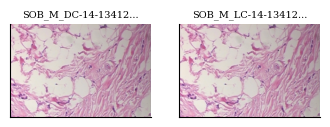

Set: 1


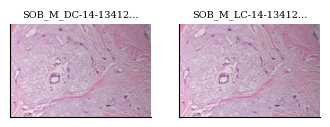

Set: 2


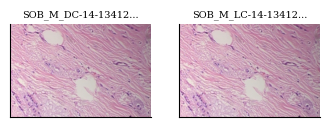

Set: 3


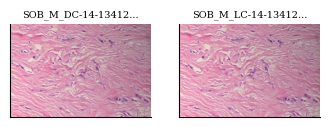

--------------------- odd_size images ----------------------

Number of examples with this issue: 74
Examples representing most severe instances of this issue:



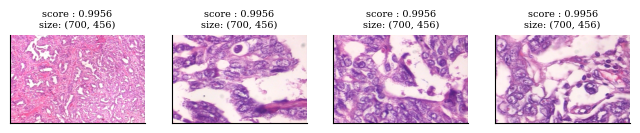

------------------ near_duplicates images ------------------

Number of examples with this issue: 6
Examples representing most severe instances of this issue:

Set: 0


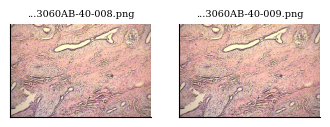

Set: 1


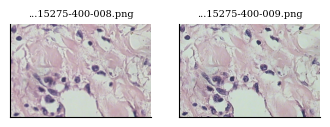

Set: 2


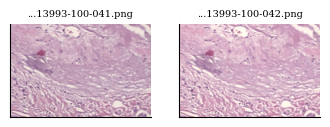

In [18]:
imagelab = Imagelab(filepaths=list(selected_fold_data["filename"]))
imagelab.find_issues()
imagelab.report(verbosity=4)

In [19]:
# Use data with magnification factor >= 200X
train = selected_fold_data.query("mag >= 200 and grp == 'train'")
test = selected_fold_data.query("mag >= 200 and grp == 'test'")
train.shape, test.shape

((2682, 5), (1151, 5))

In [20]:
train.head()

,fold,mag,grp,filename,label
30,2,200,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-001.png,benign
31,2,200,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-002.png,benign
32,2,200,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-003.png,benign
33,2,200,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-004.png,benign
34,2,200,train,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549AB/200X/SOB_B_A-14-22549AB-200-005.png,benign


In [21]:
test.head()

,fold,mag,grp,filename,label
5540,2,200,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-001.png,benign
5541,2,200,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-002.png,benign
5542,2,200,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-003.png,benign
5543,2,200,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-004.png,benign
5544,2,200,test,/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1/histology_slides/breast/benign/SOB/adenosis/SOB_B_A_14-22549G/200X/SOB_B_A-14-22549G-200-005.png,benign


(0.0, 2000.0)

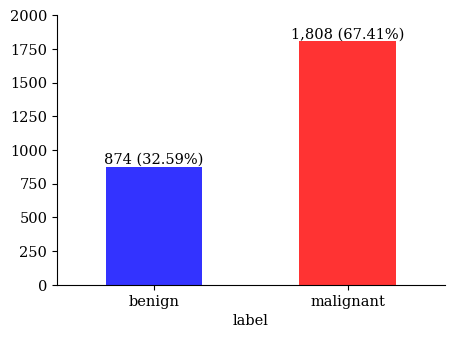

In [22]:
classes = dict(benign=0, malignant=1)
class_names = list(classes.keys())
label_counts = train["label"].value_counts(ascending=True)
ax = label_counts.plot.bar(color=["blue", "red"], alpha=0.8,
                           figsize=(5, 3.5))
ax.bar_label(ax.containers[0], padding=0.1,
             labels=[f"{x:,} ({x/len(train):.2%})" for x in label_counts])
ax.set_xticklabels(["benign", "malignant"], rotation=0);

# Set specific Y-axis limits
ax.set_ylim([0, 2000])  

In [23]:
IMG_SIZE = 224
BATCH_SIZE = 28


def load_image(filename: str, label: int) -> Tuple[tf.Tensor, str]:
    file = tf.io.read_file(filename)
    img = tf.image.decode_png(file, channels=3)
    img = tf.image.resize_with_pad(img, IMG_SIZE, IMG_SIZE)
    return img, label


# Prepare training and validation datasets
X_train, X_valid, y_train, y_valid = train_test_split(
    train["filename"], train["label"].map(classes), random_state=SEED
)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
             .map(load_image).batch(BATCH_SIZE)
validation_ds = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))\
                  .map(load_image).batch(BATCH_SIZE)
# Prepare test dataset
test = test.sample(frac=1, random_state=SEED)  # shuffle test data
test_ds = tf.data.Dataset.from_tensor_slices(
    (test["filename"], test["label"].map(classes))
).map(load_image).batch(BATCH_SIZE)

# Cache and prefetch data for faster training
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [24]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [25]:
size = 0
for _ in train_ds:
    size += 1

print("Size of train_ds dataset:", size)


Size of train_ds dataset: 72


In [26]:
size = 0
for i in validation_ds:
    size += 1

print("Size of validation_ds dataset:", size)

Size of validation_ds dataset: 24


In [27]:
size = 0
for _ in test_ds:
    size += 1

print("Size of test_ds dataset:", size)

Size of test_ds dataset: 42


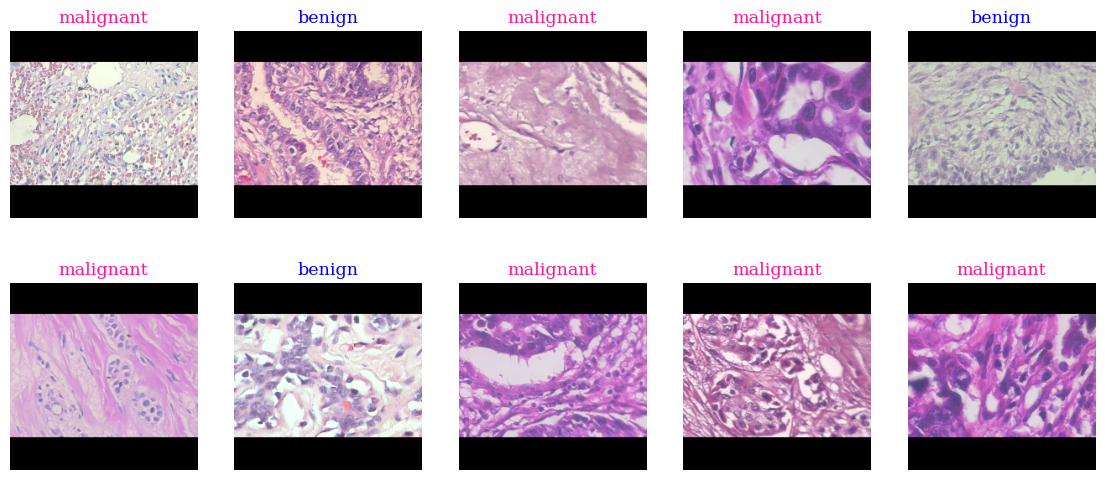

In [28]:
plt.figure(figsize=(14, 6))
for images, labels in train_ds.take(1):
    labels = labels.numpy()    
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype(np.uint8))
        label = class_names[labels[i]]
        title_color = "blue" if label == "benign" else "deeppink"
        plt.title(class_names[labels[i]], color=title_color)
        plt.axis("off")

Above code snippet creates a figure with multiple subplots, each containing an image from the first batch of a TensorFlow dataset (train_ds). The images are displayed with their corresponding labels as titles, and the title color depends on the label value. Additionally, the axis is turned off for each subplot to focus solely on the images.

## Data Augmentation

In [29]:
sample_image = load_image(*train[["filename", "label"]].iloc[0])[0]


def plot_augmentations(augmentation_layer: tf.keras.layers.Layer) -> None:
    augment_name = augmentation_layer.name
    fig, (ax0, *axes) = plt.subplots(ncols=4, figsize=(15, 4))
    ax0.imshow(sample_image.numpy().astype("uint8"))
    ax0.set_title("Original", size=14, pad=10)
    ax0.axis("off")
    for idx, ax in enumerate(axes):
        augmented_image = augmentation_layer(sample_image)
        ax.imshow(augmented_image.numpy().astype("uint8"))
        ax.set_title(augment_name.title(), size=14, pad=10)
        ax.axis("off")

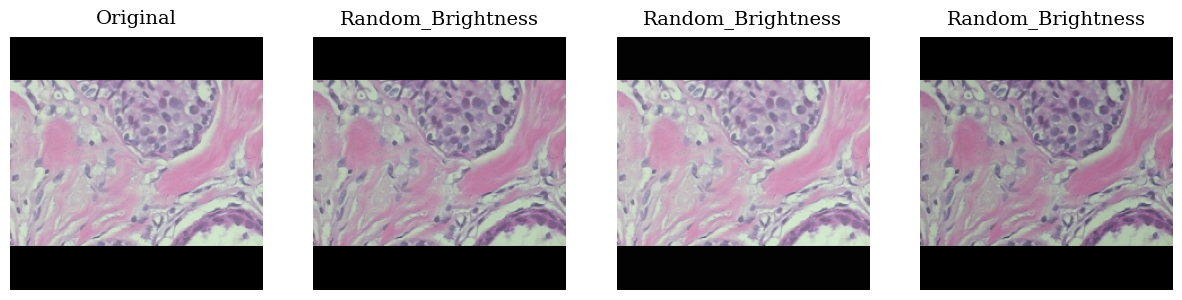

In [30]:
plot_augmentations(layers.RandomBrightness(0.2))

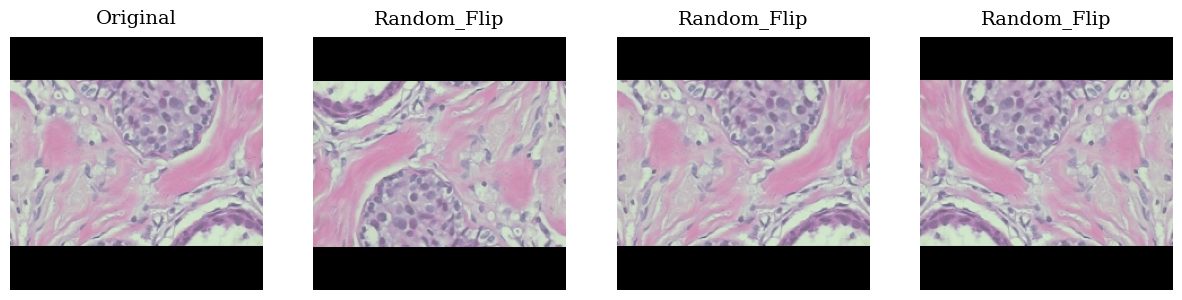

In [31]:
plot_augmentations(layers.RandomFlip())

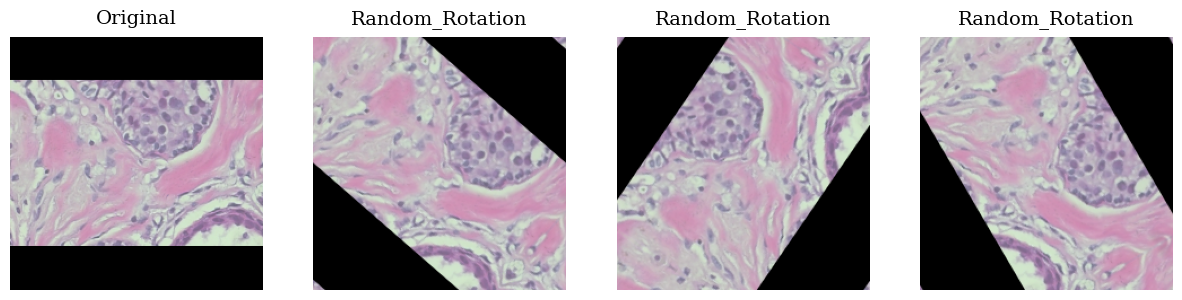

In [32]:
plot_augmentations(layers.RandomRotation(0.2, seed=SEED))

## Helper Functions

In [33]:
MAX_EPOCHS = 25
BASE_LEARNING_RATE = 0.001


def compile_and_fit_model(
    model: tf.keras.Model,
    learning_rate: float=BASE_LEARNING_RATE,
    epochs: int=MAX_EPOCHS
) -> tf.keras.callbacks.History:
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=[tf.keras.metrics.AUC(name="roc_auc"), "binary_accuracy"]
    )
    early_stopping = EarlyStopping(min_delta=1e-4, patience=5, verbose=1,
                                   restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(factor=0.5, patience=4, verbose=1)
    history = model.fit(train_ds, validation_data=validation_ds,
                        epochs=epochs, callbacks=[early_stopping, reduce_lr])
    # Plot training metrics
    performance_df = pd.DataFrame(history.history)
    fig, axes = plt.subplots(ncols=2, figsize=(11, 4))
    for ax, metric in zip(axes.flat, ["Accuracy", "Loss"]):
        performance_df.filter(like=metric.lower()).plot(ax=ax)
        ax.set_title(metric, size=14, pad=10)
        ax.set_xlabel("epoch")
    return history


def evaluate_model(model: tf.keras.Model, dataset: tf.data.Dataset=test_ds) -> None:
    loss, auc, accuracy = model.evaluate(dataset, verbose=0)
    print(f"\nROC-AUC:   {auc:.5f}", 
          f"Accuracy:  {accuracy:.5f}",
          f"Loss:      {loss:.5f}\n", sep="\n")
    # Get labels and predictions for each batch in dataset
    results = [(labels, model.predict(images, verbose=0).reshape(-1))
               for images, labels in dataset.take(-1)]
    labels = np.concatenate([x[0] for x in results])
    preds = np.concatenate([x[1] for x in results])
    # Plot metrics
    fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
    curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
    for ax, curve in zip(axes[:2], curves):
        curve.from_predictions(labels, preds, ax=ax, name=model.name)
    metrics.ConfusionMatrixDisplay.from_predictions(
        labels, preds.round().astype("uint8"), ax=axes[2], colorbar=False,
    )
    titles = ["ROC-AUC Curve", "Precision-Recall Curve", "Confusion Matrix"]
    for ax, title in zip(axes.flat, titles):
        ax.set_title(title, size=14, pad=10)


def plot_predictions(model: tf.keras.Model) -> None:
    plt.figure(figsize=(14, 9))
    for images, labels in test_ds.take(1):
        labels = labels.numpy()
        predicted_labels = model.predict(images).round().astype("uint8").reshape(-1,)
        print("Predicted:", predicted_labels)
        print("Actual:   ", labels)
        for i, (pred, actual) in enumerate(zip(predicted_labels, labels)):
            ax = plt.subplot(4, 7, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            if pred == actual:
                plt.title(class_names[labels[i]], color="green", size=9)
            else:
                plt.title(f"{class_names[predicted_labels[i]]}\n"
                          + f"(Actual: {class_names[labels[i]]})",
                          color="red", size=9)
            plt.axis("off")

## Custom CNN using tensorflow.keras API

In [34]:
custom_model = tf.keras.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    # Data augmentation
    layers.RandomBrightness(0.2, seed=SEED),
    layers.RandomFlip(seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    # Convolutional block I
    layers.Rescaling(1./255),
    layers.BatchNormalization(),
    layers.Conv2D(32, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block II
    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Convolutional block III
    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),
    # Fully connected layers
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.4),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(32, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation="sigmoid")
], name="CustomCNN")
custom_model.summary()

Model: "CustomCNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_brightness_1             │ (None, 224, 224, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,541 (525.55 KB)

 Trainable params: 134,535 (525.53 KB)

 Non-trainable params: 6 (24.00 B)

Above code defines a custom Convolutional Neural Network (CNN) model using TensorFlow's Keras API.

- First line defines the input layer of the model. It specifies that the input images have a shape of (IMG_SIZE, IMG_SIZE, 3) and 3 represents the number of channels (RGB).

- Then 3 different augmentation layers are applied RandomBrightness, RandomFlip, RandomRotation

- define the first convolutional block of the model:
        - Rescaling: Rescales the pixel values of the images to the range [0, 1].
        - BatchNormalization: Normalizes the activations of the previous layer at each batch.
        - Conv2D: Applies a 2D convolutional layer with 32 filters, each with a kernel size of 3x3, and ReLU activation function.
        - MaxPooling2D: Applies max pooling with a pool size of 2x2.
        
        
-  the second convolutional block is similar to the first one, but with more filters (64) in the convolutional layer.

- the third convolutional block with even more filters (128) in the convolutional layer.

-  the fully connected layers of the model:
        - GlobalAveragePooling2D: Computes the average of all spatial locations in the feature maps, resulting in a fixed-size output.
        - Dropout: Applies dropout regularization to prevent overfitting by randomly setting a fraction of input units to zero.
        - Dense: Fully connected layer with specified number of units and activation function. The last dense layer has a single unit with a sigmoid    activation function, suitable for binary classification tasks.
        

- summary(): This method prints a summary of the model, including information about the layers, output shapes, and the total number of parameters.

Overall, this code defines a custom CNN model for image classification with data augmentation, multiple convolutional blocks, and fully connected layers.


## Model Training

Epoch 1/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - binary_accuracy: 0.6993 - loss: 0.5786 - roc_auc: 0.6781 - val_binary_accuracy: 0.7094 - val_loss: 0.5233 - val_roc_auc: 0.8764 - learning_rate: 0.0010
Epoch 2/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - binary_accuracy: 0.8387 - loss: 0.4602 - roc_auc: 0.8381 - val_binary_accuracy: 0.7437 - val_loss: 0.4960 - val_roc_auc: 0.8765 - learning_rate: 0.0010
Epoch 3/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - binary_accuracy: 0.8403 - loss: 0.4317 - roc_auc: 0.8530 - val_binary_accuracy: 0.8063 - val_loss: 0.4375 - val_roc_auc: 0.8824 - learning_rate: 0.0010
Epoch 4/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - binary_accuracy: 0.8414 - loss: 0.4256 - roc_auc: 0.8531 - val_binary_accuracy: 0.8614 - val_loss: 0.3655 - val_roc_auc: 0.8860 - learning_rate: 0.0010
Epoch 5/25
72/72 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - binary_accuracy: 0.8383 - loss: 0.4218 - roc_auc: 0.8610 - val_binary_accuracy: 0.8644 - val_loss: 0.3635 - val_roc_auc: 0.8978

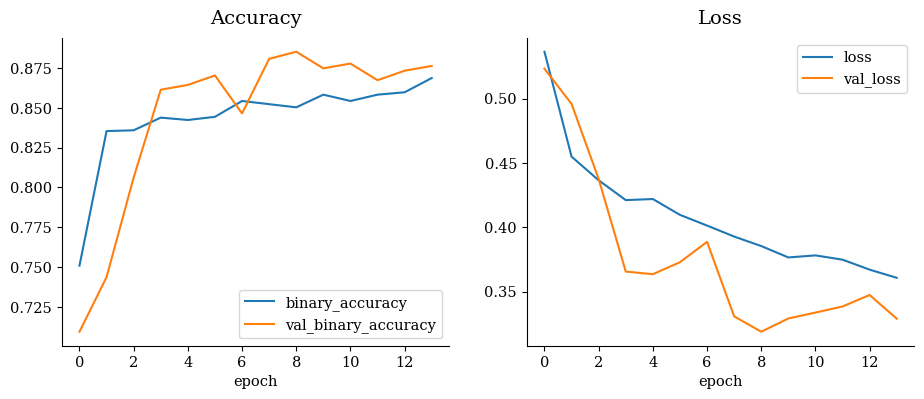

In [35]:
custom_history = compile_and_fit_model(custom_model)

## Model Evaluation


ROC-AUC:   0.85752
Accuracy:  0.83558
Loss:      0.50510



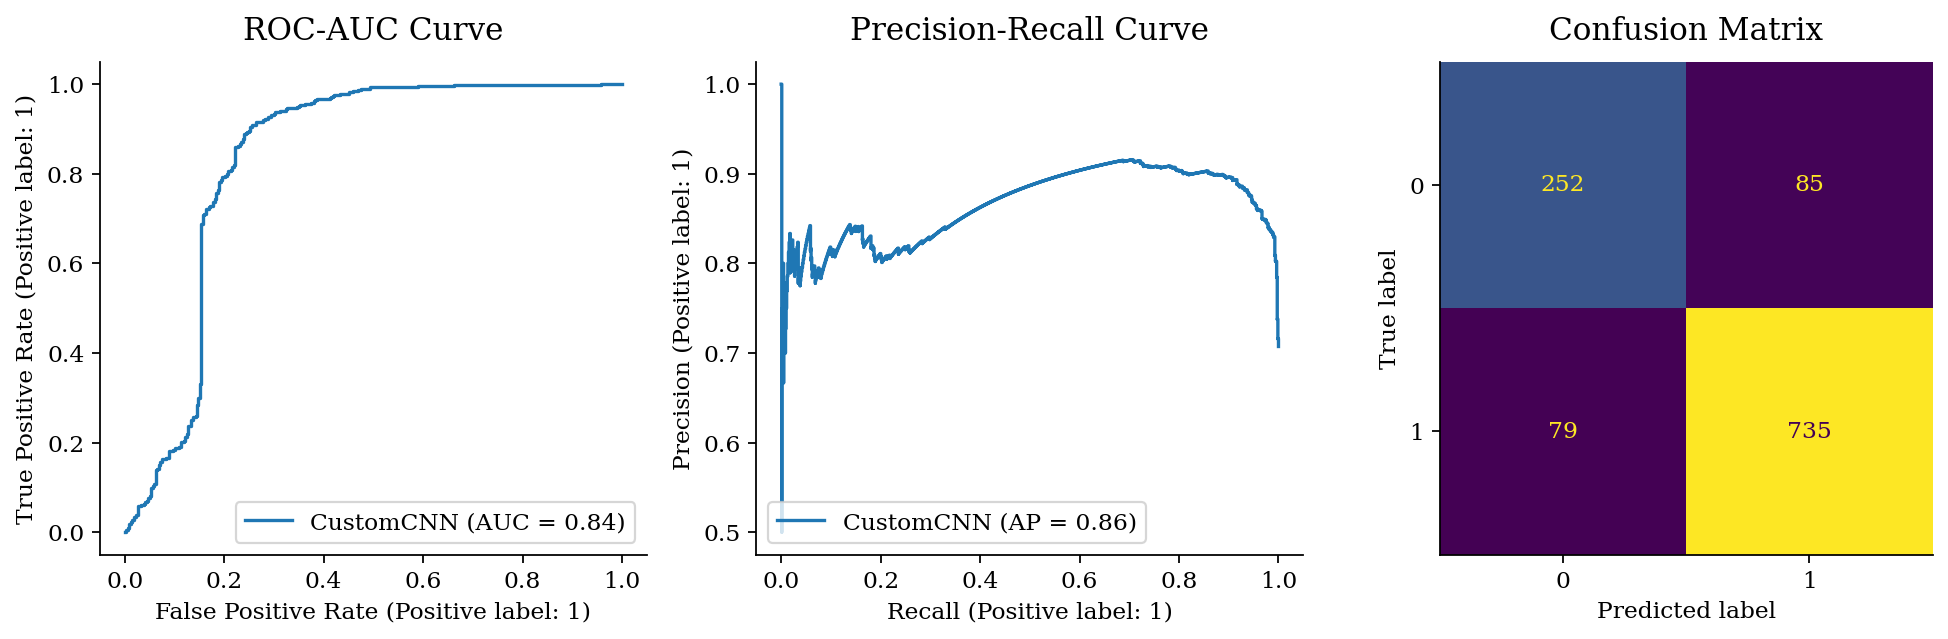

In [36]:
evaluate_model(custom_model)

## Model Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Predicted: [1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 0 0 1 0]
Actual:    [1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0]


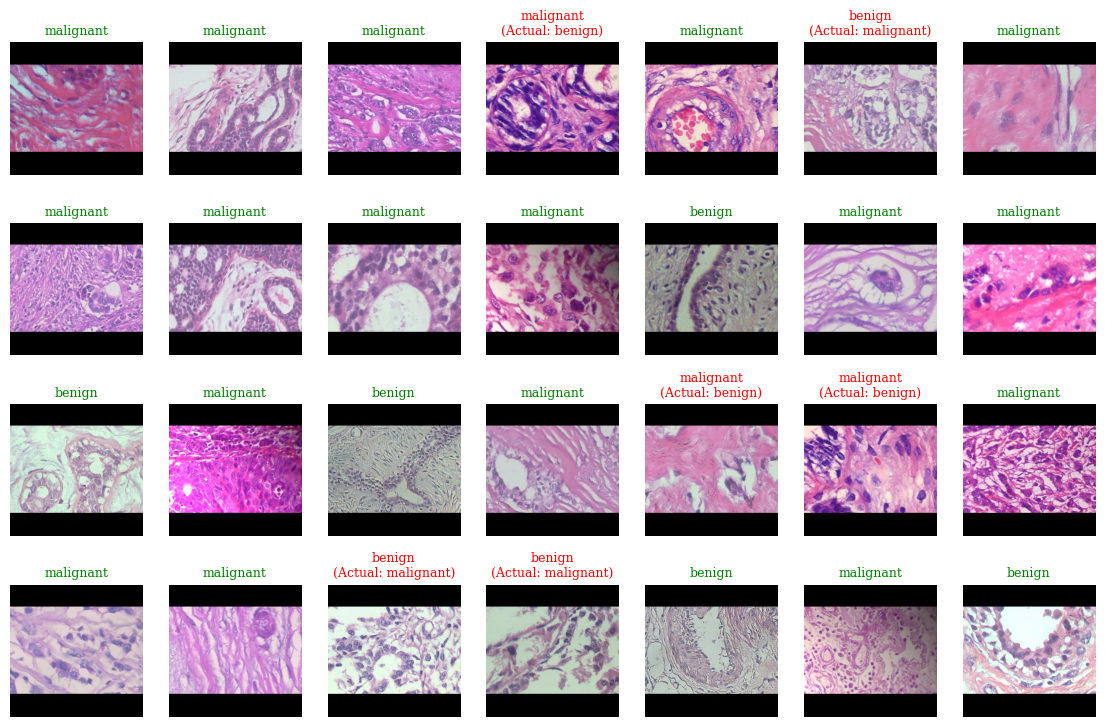

In [38]:
plot_predictions(custom_model)

## Interpretation

The custom Convolutional Neural Network (CNN) model for binary image classification has achieved the following performance metrics:

- ROC-AUC: 0.85752

The ROC-AUC score (Receiver Operating Characteristic Area Under the Curve) measures the model's ability to distinguish between the positive and negative classes. An ROC-AUC score of 0.85752 suggests that the model performs reasonably well in this regard, as it indicates that the model is capable of ranking positive instances higher than negative instances about 85.75% of the time.

- Accuracy: 0.83558

The accuracy score measures the overall correctness of the model's predictions. An accuracy of 0.83558 means that approximately 83.56% of the predictions made by the model are correct.

- Loss: 0.50510

The loss value represents the error of the model during training. It is a measure of how well the model's predictions match the true labels in the training data. A loss value of 0.50510 indicates that, on average, the model's predictions are approximately 0.50510 units away from the true labels.

## Conclusion

Thus,custom CNN model has demonstrated promising performance based on the following key metrics:
    
- ROC-AUC: The model achieves an ROC-AUC score of 0.85752, indicating its ability to effectively distinguish between positive and negative instances. With a score exceeding 0.5, the model significantly outperforms random guessing, suggesting robust discrimination capabilities.

- Accuracy: The model achieves an accuracy of 0.83558, implying that approximately 83.56% of the model's predictions are correct. While accuracy provides a general overview of the model's performance, it may not fully capture its ability to balance true positives and true negatives, particularly in imbalanced datasets.

- Loss: The model's loss value stands at 0.50510, representing the average error during training. Lower loss values indicate better alignment between predicted and true labels. While the loss is relatively moderate, further optimization may be explored to minimize discrepancies between predictions and ground truth labels.

Overall Assessment:

The model demonstrates commendable performance across multiple evaluation metrics, indicating its efficacy in binary image classification tasks. With an ROC-AUC score surpassing 0.85 and an accuracy exceeding 80%, the model showcases strong discriminative capabilities and generalization to unseen data. However, continuous refinement and validation are recommended to ensure robustness.
    
In conclusion, while the binary image classification CNN model demonstrates commendable performance, ongoing refinement and validation are crucial for ensuring its effectiveness in real-world applications.  